# Test task: Airbus ship detection
___Made by Ivan Varanytsia___
## Data Analysis
### Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL 
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras

from skimage.io import imread, imshow, concatenate_images
from skimage import io, transform
from skimage.measure import label, regionprops

### Name all paths

In [4]:
train = os.listdir("../test/train_v2")
test = os.listdir("../test/test_v2")
sub = pd.read_csv("../test/sample_submission_v2.csv", index_col=0).dropna()

data_root = "../test"
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')

print(f"Train files: {len(train)}")
print(f"Test files :  {len(test)}")

print("The dimension of the images is: "+str(PIL.Image.open("../test/train_v2/00a52cd2a.jpg").size))

Train files: 192558
Test files :  15606
The dimension of the images is: (768, 768)


### What is in our dataset?

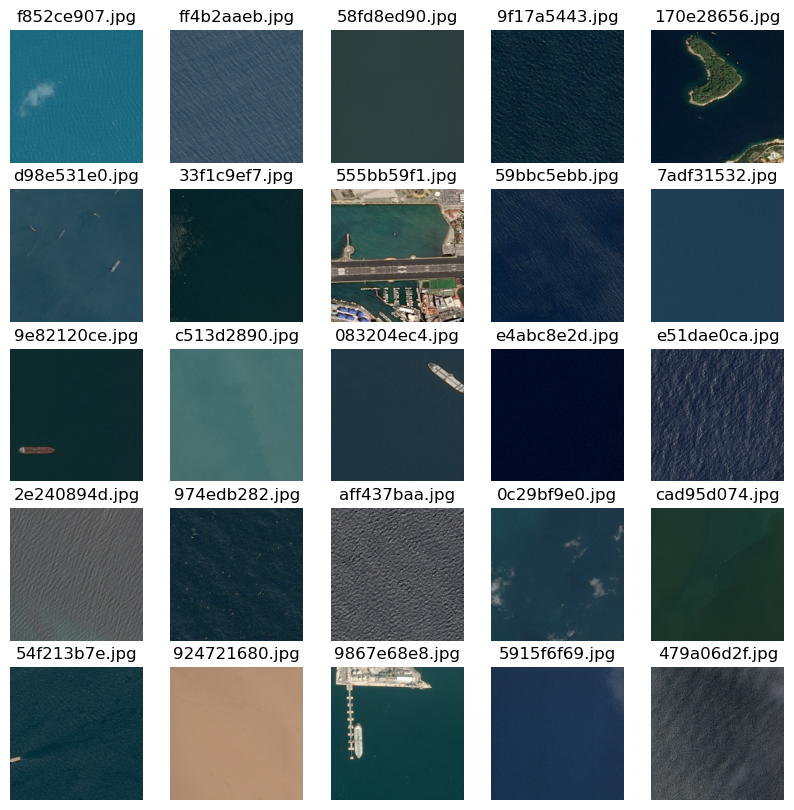

In [5]:
w = 5
h = 5

load_img = lambda filename: np.array(PIL.Image.open(f"../test/train_v2/{filename}").resize((200, 200)))

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h)) 

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train) 
        ax.imshow(load_img(img)) 
        ax.set_title(img)

### CSV File with coordinates of masks 

In [6]:
df = pd.read_csv("../test/train_ship_segmentations_v2.csv", index_col=0).dropna()
df_copy = pd.read_csv("../test/train_ship_segmentations_v2.csv", index_col=0)
df_copy.head()

,EncodedPixels
ImageId,
00003e153.jpg,NaN
0001124c7.jpg,NaN
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### Check how much images with ships do we have

In [7]:
df_wships = df_copy.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = df_copy[df_copy['EncodedPixels'].isna()]

print('Number of images with ships:     %d \nNumber of images without ships: %d\nProportion: %0.1f\n' %
      (df_wships.shape[0], df_woships.shape[0], df_wships.shape[0] / df_woships.shape[0]))

ratio_with_ships = df_wships.shape[0] / len(train)
ratio_without_ships = df_woships.shape[0] / len(train)
print('Ratio with ships:     ' + str(round(ratio_with_ships, 2)))
print('Ratio without ships:  ' + str(round(ratio_without_ships, 2)))

Number of images with ships:     42556 
Number of images without ships: 150000
Proportion: 0.3

Ratio with ships:     0.22
Ratio without ships:  0.78


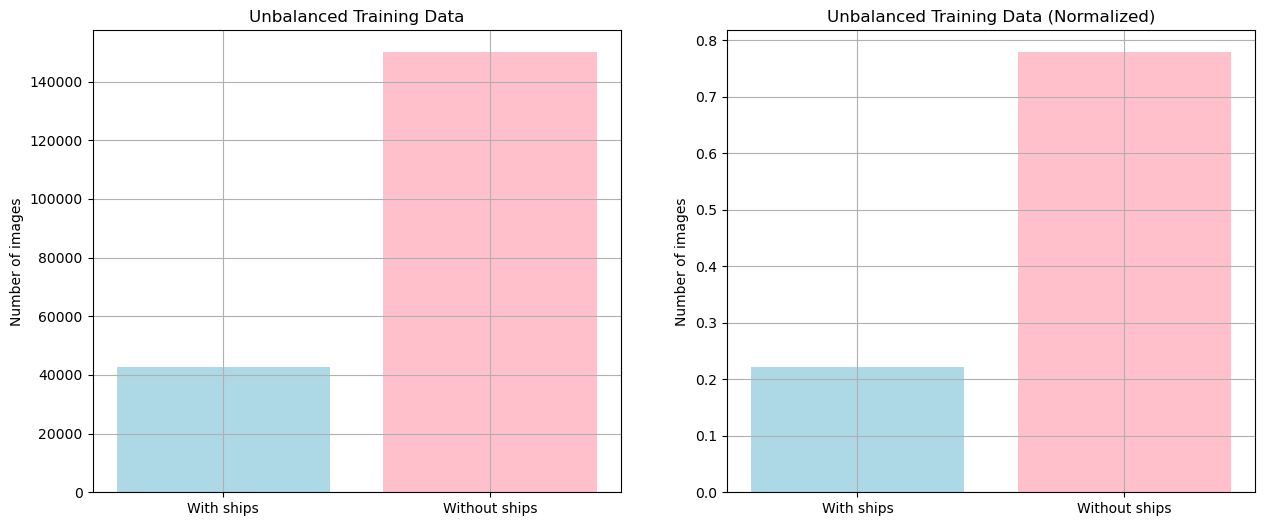

In [8]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(['With ships', 'Without ships'], [len(df_wships), len(df_woships)], color=['lightblue', 'pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Training Data')
plt.grid()

plt.subplot(1, 2, 2)
plt.bar(['With ships', 'Without ships'], [ratio_with_ships, ratio_without_ships], color=['lightblue', 'pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Training Data (Normalized)')
plt.grid()

plt.show()

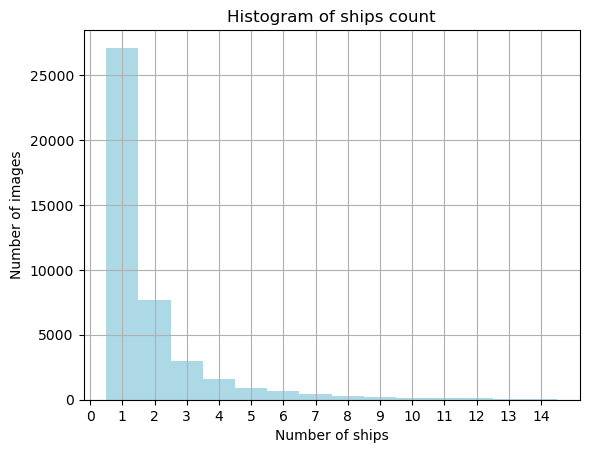

In [9]:
hist = df_wships.hist(bins=np.arange(df_wships['counts'].max()) + 0.5, color='lightblue')
plt.xticks(range(15))
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

### Images vizualization

In [10]:
def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

In [11]:
def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()] 
    
    pixel = [
        (pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)] 
    return pixel

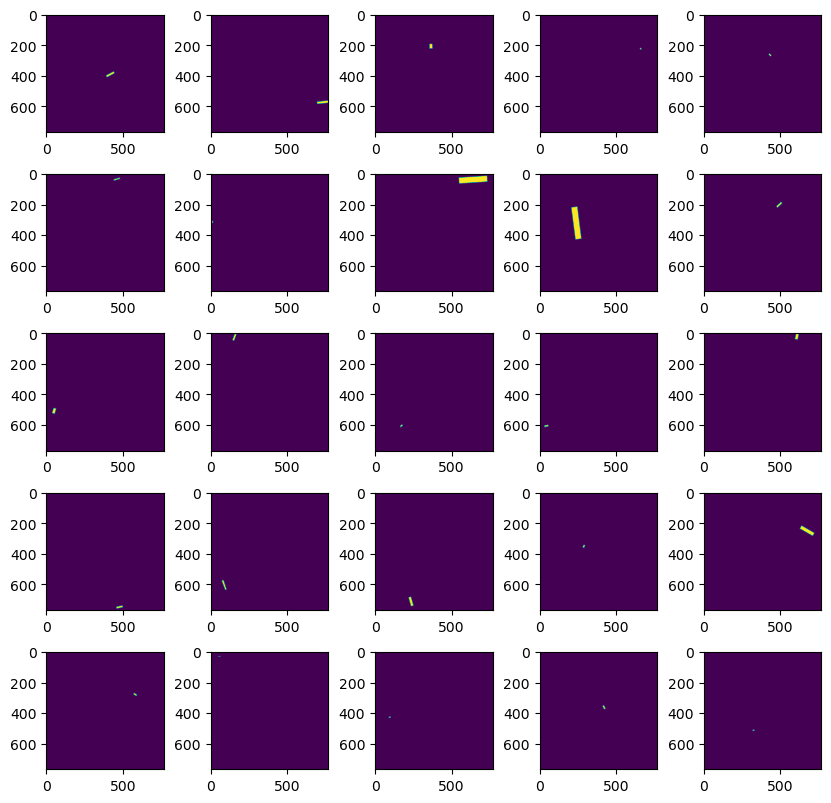

In [12]:
w = 5
h = 5

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))
plt.subplots_adjust(wspace=0.4)
ax.set(xlim=(0, 768), ylim=(0, 768))
for axes in axes_list:
    for ax in axes:
        ax.axis('auto')
        canvas = np.zeros((768, 768))
        pixels = rle_to_pixels(np.random.choice(df['EncodedPixels']))
        canvas[tuple(zip(*pixels))] = 1
        ax.imshow(canvas);

In [15]:
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index().dropna()
load_img = lambda filename: np.array(PIL.Image.open(f"../test/train_v2/{filename}"))

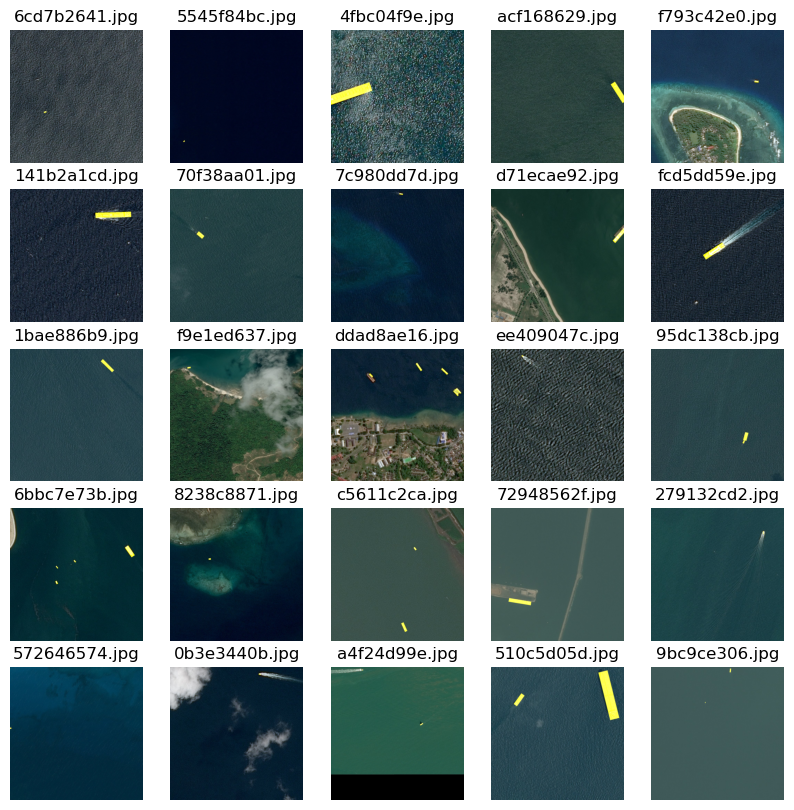

In [16]:
w = 5
h = 5

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId']), rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))
        ax.set_title(df.loc[row_index, 'ImageId'])